In [1]:
from cooking_bot.data_formats import *
from cooking_bot.encoders import get_clip_text_embedding, get_image_embedding, get_sentence_embedding, CLIP_MODEL, SENTENCE_TRANSORMER
from cooking_bot import REPO_PATH
from glob import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import bertviz
from IPython.display import display
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
os.chdir(REPO_PATH)

In [2]:
recipes = []

for id, path in enumerate(tqdm(glob("jsons/*.json"), "Filling Index")):
    
    with open(path, "r") as f:

        data = f.read()
    
    recipe = Recipe.model_validate_json(data)
    recipes.append(recipe)

Filling Index: 100%|██████████| 994/994 [00:03<00:00, 290.07it/s]


In [3]:
many_instructions = [i for i in recipes if len(i.instructions) > 6]

def number_of_images(x : Recipe):
    
    s = 0
    
    for i in x.instructions:
        for img in i.stepImages:
            s += img.embedding is not None
            
    return s




many_instructions.sort(key=number_of_images, reverse=True)

len(many_instructions)

291

In [4]:
def num_images(a : List[Images]):
    
    return sum(i.embedding is not None for i in a)

In [5]:
all_tools = [tool for recipe in recipes for tool in recipe.tools]
tool_imags = [num_images(i.images) for i in all_tools]
len(all_tools), sum(tool_imags)

(602, 0)

In [6]:
all_ingredients = [ingredients for recipe in recipes for ingredients in recipe.ingredients]
ingr_imags = [num_images(i.images) for i in all_ingredients]
len(all_ingredients), sum(ingr_imags)

(10241, 0)

In [7]:
all_instructions = [instructions for recipe in recipes for instructions in recipe.instructions]
ins_imags = [num_images(i.stepImages) for i in all_instructions]
len(all_instructions), sum(ins_imags), sum(i for i in ins_imags)/ len(all_instructions)

(5425, 802, 0.14783410138248848)

In [8]:
max(ins_imags), 804/5425

(1, 0.14820276497695853)

In [9]:
recipes_imags = [num_images(i.images) for i in recipes]
len(recipes), sum(recipes_imags)

(994, 996)

In [10]:
with_img = [i for i in recipes if len(i.images)]


In [11]:
recipe : Recipe = many_instructions[6]



number_of_images(recipe), len(recipe.instructions)

(11, 12)

In [19]:
recipe : Recipe = many_instructions[15]



number_of_images(recipe), len(recipe.instructions), recipe.displayName

(10, 11, 'Banana Bread')

In [12]:
ins = [i for i in recipe.instructions if i.stepImages]
print([i.stepNumber for i in ins])
vecs = np.array([i.stepImages[0].embedding for i in ins])
imgs = [i.stepImages[0].get_image() for i in ins]

texts = [i.stepText for i in ins]
text_emb= np.array([get_clip_text_embedding(i) for i in texts])

[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12]


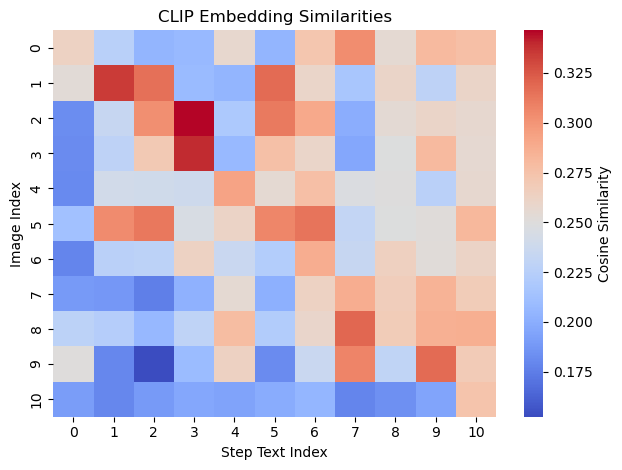

In [13]:
sim = vecs @ text_emb.T

# Create the heatmap
sns.heatmap(sim, cmap='coolwarm', cbar=True,
            cbar_kws={'label': 'Cosine Similarity'})  # coolwarm is a good diverging colormap

# Enhancements for paper
plt.title('CLIP Embedding Similarities')
plt.xlabel('Step Text Index')  # Adjust label as needed
plt.ylabel('Image Index')  # Adjust label as needed
plt.tight_layout()  # Adjust layout to fit everything nicely

plt.savefig("imgs/clip.png", )
plt.show()